<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
from pathlib import Path
from google.colab import files, drive
from collections import defaultdict

import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'transcriptions'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Let's look at the data in given file

In [265]:
with data_file.open() as f:  
    print(list(f.readline()))

['а', 'у', 'к', 'ц', 'и', 'о', 'н', 'ы', ' ', 'н', 'а', ' ', 'д', 'е', 'ш', 'ё', 'в', 'о', 'е', ' ', 'ж', 'и', 'л', 'ь', 'ё', ' ', 'п', 'р', 'о', 'в', 'о', 'д', 'я', 'т', 'с', 'я', ' ', 'р', 'е', 'г', 'у', 'л', 'я', 'р', 'н', 'о', '\t', '%', '%', ' ', 'a', ' ', 'u', ' ', 'k', ' ', 't', 's', ' ', 'y', ' ', 'o', '1', ' ', 'n', ' ', 'a', 'x', ' ', '#', ' ', 'n', ' ', 'a', 'x', "'", ' ', '_', ' ', 'd', "'", ' ', "'", 'i', ' ', 's', 'h', ' ', 'o', '1', ' ', 'v', ' ', 'a', 'x', "'", ' ', 'j', 'a', 'x', ' ', '#', ' ', 'z', 'h', ' ', 'y', "'", ' ', 'l', "'", ' ', 'j', "'", ' ', "'", 'o', '1', ' ', '#', ' ', 'p', ' ', 'r', ' ', 'a', ' ', 'v', ' ', 'o', "'", '1', ' ', 'd', "'", ' ', "'", 'a', 'x', ' ', 't', 's', ' ', 't', 's', ' ', 'a', 'x', "'", ' ', '#', ' ', 'r', "'", ' ', "'", 'i', 'x', ' ', 'g', ' ', 'u', "'", ' ', 'l', "'", ' ', "'", 'a', '1', ' ', 'r', ' ', 'n', ' ', 'a', ' ', '%', '%', '\n']


#### Notice that:
1. russian sentence is separated from transcript with '\t'
2. the begining and the end of transcript part are marked by '%%'

### Let's read the data and split it into rus and trans with '\t'

In [266]:
rus_trn = []
with data_file.open() as f:  
  for line in f: 
    rus, trn = line.split('\t')
    rus_trn.append([rus.strip(), trn.strip()])

print(f'Number of sentences in corpus: {len(rus_trn)}')

Number of sentences in corpus: 50277


##### Let's look at some sentences


In [267]:
print(rus_trn[13][0])
print(rus_trn[13][1])
print(rus_trn[24][0])
print(rus_trn[24][1])


устрицы подают с простыми винами типа рислинга
%% u1 s t r' 'ix ts ax # p ax d a' j' 'u1 t # s _ p r a s t y'1 m' 'ix' # v' 'i1 n ax' m' 'ix' # t' 'i1 p ax' # r' 'i1 s l' 'ix n g a %%
отношение числа городских и сельских жителей четыре к одному
%% a t n a sh e'1 n' 'ix' jax' # ch' 'i s l a1 # g ax r a ts k' 'i1 h # y' _ s' 'e'1 l' s k' 'ix gh # zh y'1 t' 'ix' l' 'ix' j' %% %% ch' 'i t y'1 r' 'ix # k _ ax d n a m u1 %%


#### Notice that words in russian sentence are separated by space while words in translit are separated:
1. by '#' in general case
2. by '_' in case of preposition
3. by '%% %%' in case of dash (?)


#### Let's see if we have dupliates in cirpus

In [279]:
a = array(rus_trn)
seen_rus = Counter(a[:,0])
seen_trn = Counter(a[:,1])

print(f'Unique rus sentenses: {len(seen_rus)} out of {len(rus_trn)}')
print(f'Unique trans sentenses: {len(seen_trn)} out of {len(rus_trn)}')

Unique rus sentenses: 3131 out of 50277
Unique trans sentenses: 3171 out of 50277


#### We have a lot of duplicates! Only 3131 unique sentenses out of 50K in corpus. Please also note that some russian sentences are transcribed into different transcriptions (will look into that later on)

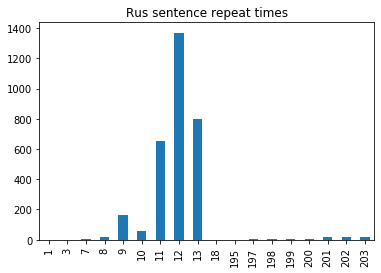

In [276]:
lens = [each[1] for each in seen_rus.items()]
unq = np.unique(lens)
qty = [lens.count(each) for each in unq]
pd.DataFrame(qty, index=unq).plot.bar(title = 'Rus sentence repeat times', legend=False);

#### Most duplicated sentences repeat 12 times, max up to 203 times

### Let's read that data while splitting the words. We'll count the words in each sentence. The hypotesis is that number of words in rus and trans are the same. If this is true we could transcribe using words

Anomalies: 1


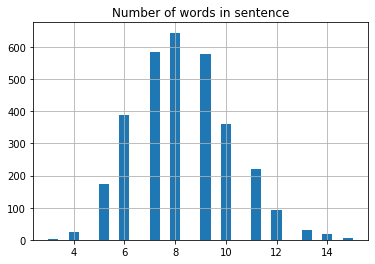

In [285]:
import re

rus_l, trn_l, anomaly = [], [], []
seen = defaultdict(list)
chars = Counter()

for j,i in enumerate(rus_trn):
      rus = i[0].split()
      trn = re.split('#|_|%% %%',i[1])

      if i[0] not in seen:
        if abs(len(rus) - len(trn)) > 1: 
          anomaly.append(i)
        else:
          rus_l.append(len(rus))
          trn_l.append(len(trn))

        chars += Counter(i[0])  

      seen[i[0]].append(j)

print(f'Anomalies: {len(anomaly)}')
pd.DataFrame({'Number of words in sentence':rus_l}).hist(bins = 30);

#### So in all but one cases number of words in rus and trans is the same. Sentence lenth varies from 3 to 15 words

### Let's see if we need to clead the data. First let's take a look in rus corpus alphabet

159

Number of times "-" used: 159


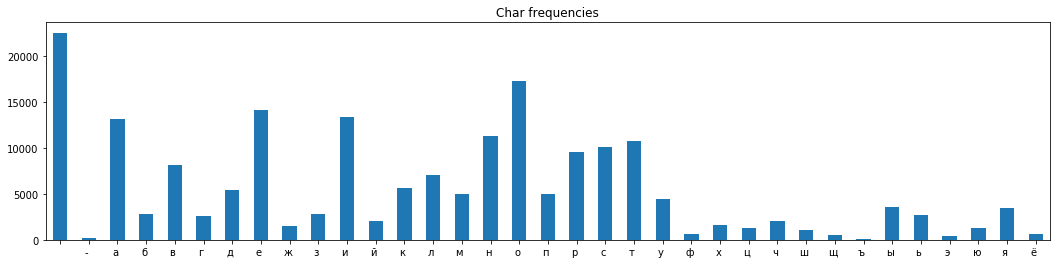

In [299]:
s = sorted(chars.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Char frequencies', legend=False)
print(f'Number of times "-" used: {chars["-"]}')

#### Looks good! We neither have punctuations nor capital letters. The only case to check is '-' letter which is used 159 times